<a href="https://colab.research.google.com/github/aharrisonau/Task8.1HD/blob/main/Task_8_1HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 8.1HD**

This task is to use the LunarLander-v2 environment to demonstrate the findings that are presented in "State Distribution‐aware Sampling for Deep Qlearning"
https://arxiv.org/abs/1804.08619v1

The basic framework of the Notebook has been taken from Practical 9 and adapted.  All the significant changes have been highlighted and commented

We commence by intalling the required packages.

In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (1,182 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160706 file

## Local Sensitve Hashing - Simhash

The method will also require a Locally Sensitive Hashing implementation for clustering of the state spaces in the replay buffer. I have chosen to use the SimHash implementation at https://github.com/sean-public/python-hashes

In [2]:
#################################
# New code added to Practical 9 #
#################################
# import the environment
# helper code from https://stackoverflow.com/questions/55835318/how-to-create-and-use-a-custom-openai-gym-environment-on-google-colab
%%capture
!git clone https://github.com/sean-public/python-hashes
!pip install -e python-hashes

After running the cell above, restart the runtime or the cell below will fail

In [1]:
#################################
# New code added to Practical 9 #
#################################
from hashes.simhash import simhash
print(simhash("I am a person"))
print(simhash("I am a person."))

11268081530936808
12406936047824332


In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
#from gridWorldGame import standard_grid, negative_grid,print_values, print_policy


Mounted at /content/drive


This simhash implementation is intended for application on text strings and needs to be adapted for application on normalised numerical vectors of the kind used in lunarlander state space.

This is done below as simhashNV

In [3]:
#################################
# New code added to Practical 9 #
#################################
from hashes.hashtype import hashtype

class simhashNV(hashtype):
    def create_hash(self, vector):
        """This is an adaptation of simhash for application to a
        normalised numerical vector
        """
        v = [0]*self.hashbits # set an array of zeros to collect the hash
        for j in range(len(vector)):
          t = self._dimension_hash(j) # get a random vector for each dimension
          bitmask = 0
          for i in range(self.hashbits):
            bitmask = 1 << i
            if t & bitmask: # step through the returned vector and add
                            # or subtract the dimension weight (vector value)
                v[i] += 1*vector[j]
            else:
                v[i] -= 1*vector[j]

        # once the hash vector is finished, calculate the binary fingerprint
        fingerprint = 0  
        for i in range(self.hashbits):
            if v[i] >= 0:
                fingerprint += 1 << i
        self.hash = fingerprint
        return fingerprint

    def _dimension_hash(self, v):
        """This generates a pseudo random hash from the dimension number of
        of the vector component.
        """
        if v == "":
            return 0
        else:
            x = (v+1) << 7
            m = 1000003
            mask = 2 ** self.hashbits-1
            x = ((x*m) ^ (v+1)) & mask
            x ^= 3
            if x == -1:
                x = -2
            return x

    def similarity(self, other_hash):
        """Calculate how similar this hash is from another simhash.
        Returns a float from 0.0 to 1.0 (linear distribution, inclusive)
        """
        if type(other_hash) != simhashNV:
            raise Exception('Hashes must be of same type to find similarity')
        b = self.hashbits
        if b != other_hash.hashbits:
            raise Exception('Hashes must be of equal size to find similarity')
        return float(b - self.hamming_distance(other_hash)) / b

Run a quick test to make sure that the simhashNV class is working

In [4]:
#################################
# New code added to Practical 9 #
#################################
hash1 = simhashNV([0.9,0.25,0.3,0.43],8)
hash2 = simhashNV([-0.9,0.25,0.8,0.43],8)
print(hash1)
print(hash2)
print(hash1.similarity(hash2))
int(hash1)

130
5
0.5


130

We also need to set up the file names and the display. The code in the cell below creates a virtual display in the background that the Gym environment can connect to for rendering. 


In [5]:
# Setting up the filenames and paths for videos and temp files
import pyvirtualdisplay

!mkdir vid
!rm ./vid/*.*
!mkdir agent

video_name = "./vid/Practical_9_vid01.mp4"
agent_name = "./agent/StateFile.zip"

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

rm: cannot remove './vid/*.*': No such file or directory


## Deep Q-Network

Minh et al 2015 as many other papers departs from the notion that the optimal action-value function should be given by

$$ Q^*(s, a) = \max_{\pi} \mathbb{E}\Bigg[\sum_{s=0}^{\infty} \gamma^s r_{t+s} | s_t=s, a_t=a, \pi \Bigg] $$

which is the maximum sum of rewards $r_t$ discounted by $\gamma$ at each time-step $t$ achievable by a behaviour policy $\pi = P(a|s)$, after making an observation of the state $s$ and taking an action $a$. 

The main difference is that it uses a  uses deep (convolutional) neural network to approximate the Q-value function. In the paper the authors use *experience replay* so as to randomis the data. They also use iterative updates that adjust the action-values, $Q$, towards target values, $Q'$.

In the paper, the network is used as an approximator of the function $Q$. The  input to the DQN architecture is the state representation. The output units correspond to the predicted $Q$-values of the individual actions for the input state. In their implmentation, Minh et al defined the input to the neural network as an 84 x 84 x 4 image produced by a preprocessing map $\phi$. 

The network has four hidden layers:

* Convolutional layer with 32 filters (each of which uses an 8 x 8 kernel and a stride of 4) and a ReLU activation function. 
* Convolutional layer with 64 filters (each of which using a 4 x 4 kernel with stride of 2) and a ReLU activation function. 
* Convolutional layer with 64 filters (each of which uses a 3 x 3 kernel and a stride of 1) and a ReLU activation function. 
* Fully-connected (i.e., dense) layer with 512 neurons followed by a ReLU activation function.

The output layer is another fully-connected layer with a single output for each action. A representaion of the DQN architecture from the paper is reproduced in the figure below. 

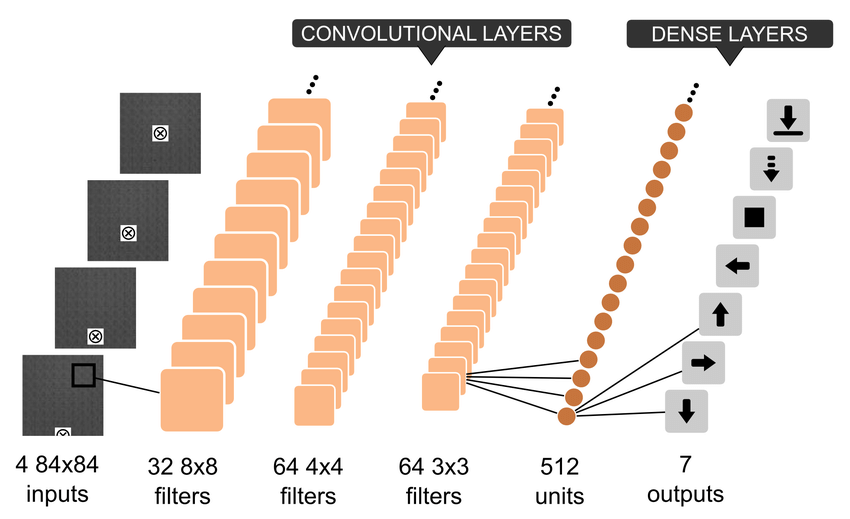

The PyTorch implementation of the DQN architecture above is given below

In [6]:
import typing

import torch
from torch import nn


QNetwork = nn.Module

class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)

def make_deep_q_network_fn(action_size: int) -> typing.Callable[[], QNetwork]:
    
    def deep_q_network_fn() -> QNetwork:
        q_network = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
            nn.ReLU(),
            LambdaLayer(lambda tensor: tensor.view(tensor.size(0), -1)),
            nn.Linear(in_features=25024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=action_size)
        )
        return q_network
    
    return deep_q_network_fn

## Experience Replay

The method employs a Deep Q-Learning approach with Experience Replay that is very similar to that implemented in Practical 9.  However, there is significant modification at;
- steps 7-9: use the simhash algorithm to cluster states according to their hash values
- step 10: batch sample transitions based on the probablities using the "state-aware" methodology of this article
- step 13: periodically reset the target Q function to equal the local Q function

. This is given by the following pseudocode which is taken from Weichao et.al. (2018)

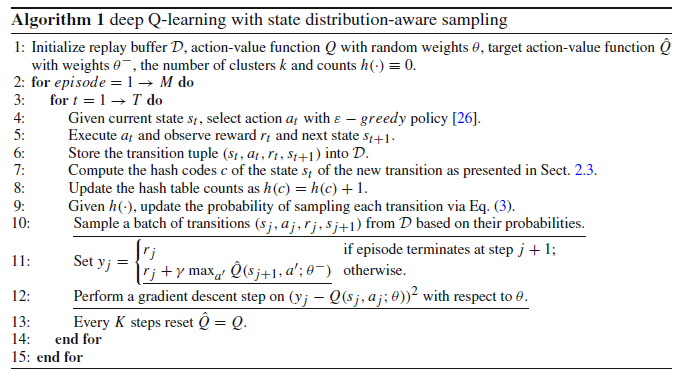

To perform *experience replay* the authors store the agent's experiences $e_t$ as represented by the tuple

$$ e_t = (s_t, a_t, r_t, s_{t+1},c) $$

consisting of the observed state in period $t$, the reward received in period $t$, the action taken in period $t$, the resulting state in period $t+1$. The dataset of agent experiences at period $t$ consists of the set of past experiences.  For this method, the cluster (c) of each state must also be recorded to allow for uniform cluster sampling.

$$ D_t = \{e1, e2, ..., e_t \} $$

During learning Q-learning updates are computed based on samples (or minibatches) of experience $(s,a,r,s')$, drawn the pool of stored samples $D_t$.  For the state aware method proposed, states in the replay buffer are clustered using the simhash algorithm and then sampling is mixed between uniform sampling from the complete buffer and uniform sampling from the clusters according to a mixing parameter $\beta\$ 

The replay buffer is comprised by a set number of steps (observations), where each state, action, future state and status are recored every four environment steps. The following is the implmentation of the experience replay. 

In [22]:
import collections
import typing

import numpy as np

#################################
# Code modified from Practical 9 #
#################################
hash_clusters = 50
# this sets roughly how many clusters the state aware mechanism will use
# it sets the number of hashbits that will be used and the maximum clusters
# is 2**number_hashbits

_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done",
    "cluster"
]
# note the addition of the cluster to each experience
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self,
                 batch_size: int,
                 hashbits: int,
                 beta: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
        
        """
        self._batch_size = batch_size
        self._hashbits = hashbits
        self._beta = beta
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        self._cluster_count = [0] * 2**hashbits
        # this will hold the count of the cluster size as experiences are
        # added and clustered
        
    def __len__(self) -> int:
        return len(self._buffer)
    
    @property
    def batch_size(self) -> int:
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        return self._buffer_size

    def is_full(self) -> bool:
        return len(self._buffer) == self._buffer_size
    
    def append(self, part_experience) -> None:
        """Add a new experience to memory."""
        
        # as well as adding the experience, we need to add the count to 
        # track how many experiences are inside each cluster
        cluster = int(simhashNV(part_experience[0],self._hashbits))
        part_experience.append(cluster)
        experience=Experience(*part_experience)
        self._buffer.append(experience)
        self._cluster_count[cluster] += 1
    
    def sample(self) -> typing.List[Experience]:
        #################################
        # New code added to Practical 9 #
        #################################
        
        """Randomly sample a batch of experiences from memory.
        The method has been adjusted to be state aware.  That is to make a sample,
        it selects a cluster at random and then an experience from that cluster.
        The beta parameter controls the ratio between uniform and state aware
        sampling (beta = 1 means all uniform sampling)
        """
        
        if np.random.random()<self._beta:
          # do uniform sample
          idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
          experiences = [self._buffer[idx] for idx in idxs]

        else:
          # build a state aware sample
          experiences = collections.deque() # initialize an empty sample
          
          # get the set of non-empty clusters
          sets = []
          for i in range(2**self._hashbits):
            subset = [ex for ex in self._buffer if ex.cluster==i]
            if len(subset)!=0:
              sets.append(subset)
          set_count = len(sets)

          # build an experience sample
          for i in range(self._batch_size):  # loop through to select samples
            subset=sets[np.random.randint(set_count)]
            experience = subset[np.random.randint(len(subset))]
            experiences.append(experience)

        return experiences


## Setting-up the Environment

As mentioned above, here we will use the DQN algorithm to train an agent to solve the [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) environment from [OpenAI](https://openai.com/).

In this environment the landing pad is always at coordinates (0,0). The reward for moving the lander from the top of the screen to landing pad and arriving at zero speed is typically between 100 and 140 points. Firing the main engine is -0.3 points each frame (so the lander is incentivized to fire the engine as few times possible). If the lander moves away from landing pad it loses reward (so the lander is incentived to land in the designated landing area). The lander is also incentived to land "gracefully" (and not crash in the landing area!).

A training episode finishes if the lander crashes (-100 points) or comes to rest (+100 points). Each leg with ground contact receives and additional +10 points. The task is considered "solved" if the lander is able to achieve 200 points (I will actually be more stringent and define "solved" as achieving over 200 points on average in the most recent 100 training episodes).

There are four discrete actions available: 

0. Do nothing.
1. Fire the left orientation engine.
2. Fire main engine.
3. Fire the right orientation engine.

In [8]:
env_id = 'LunarLander-v2'
print("Current config is:")
print(env_id)

Current config is:
LunarLander-v2


In [9]:
import gym

env = gym.make(env_id)
_ = env.seed(42)

To show our results we will use a video player of the simulation. Hence, we define the show_video routine below

In [10]:
# Setup the routine to show the video
import base64
import io
from IPython import display

def show_video(video_name):

  video = io.open(video_name, 'r+b').read()
  encoded = base64.b64encode(video)

  display.display(display.HTML(data="""
    <video alt="test" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
    """.format(encoded.decode('ascii'))))

## Defining a Generic Agent and Train Routine

In the cells below we proceed to define a generic training loop for training and an `Agent` to solve a task in a given `gym.Env` environment. Note these are very much a standard training routine with a pre-processing option for the Gym environment and an agent based upon the deep Q-Network shown before. 



### Training Scheme

In their paper, the Google Deepmind researchers  used a crop, resize and grayscale of the frame for the Atari game. This image was then stacked into the last four frames in the game whereby each of these had been pre-processed in the same manner. As a result, the actual observation is comprised of four frames "stacked" onto each other where each has been croped a size 84x84, which yields a tensor input of size 4x84x84 ndarray.

In the case of the Lunar Lander, we can take the actual environment states as they are and stack them. The implemetation is as follows

In [11]:
import cv2

class Agent:
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError

def preprocess_step(state):
    img_size = (84, 84)
    pp_state = state[34:-16, 8:-8, :]
    pp_state = cv2.resize(pp_state, img_size)
    pp_state = pp_state.mean(-1, keepdims=True)  # grayscale
    pp_state = pp_state.astype('float32') / 255.
    pp_state = pp_state.reshape(-1)
    return pp_state

def _train_for_at_most(agent:Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)        
        agent._step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        agent._step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score

def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.
    
    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timsteps (int): maximum number of timesteps per episode.
    
    Returns:
    --------
    scores (list): collection of episode scores from training.
    
    """
    #scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        agent.scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            epsilon = agent._epsilon_decay_schedule(agent._number_episodes)
            print(f"\rEpsilon at episode {i + 1} is {epsilon:.2f} with an average score of: {average_score:.2f}")
        if (i + 1) % 50 == 0:
            agent.save(agent_name)
            
    return agent.scores

### Creating a Deep Q-Agent - modified for Double DQN

We can now proceed to define the Deep Q-Agent in the cell below. Here, we  encapsulate the generic agent in a `DeepQAgent` class. As mentioned above, the agent uses a simple three layer dense neural network with ReLU activation functions to approximate the action-value function $Q$.

Note the $Q$-learning update from Mihn et.al., as used in Practical 9, is that iteration $i$ uses the following loss function

$$ \mathcal{L_i}(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \Bigg[\bigg(r + \gamma \max_{a'} Q\big(s', a'; \theta_i^{-}\big) - Q\big(s, a; \theta_i\big)\bigg)^2\Bigg] $$

This is modified by Weichao et.al. to use the Double Q method proposed by van Hasselt (2015).  The loss function in this case is;

$$ \mathcal{L_i}(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \Bigg[\bigg(r + \gamma  Q\big(s',arg\max_{a} (s',a ; \theta_i\big);\theta_i^{-} - Q\big(s, a; \theta_i\big)\bigg)^2\Bigg] $$

where $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the $Q$-network at iteration $i$ and $\theta_i^{-}$ are the $Q$-network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^{-}$ are only updated with the $Q$-network parameters $\theta_i$ every $C$ steps and are held fixed between individual updates. 

The key difference with this change is that the action is selected with argmax from the online Q network, but the action is evaluated from the target network.  This change has been rolled through the remainder of this implementation

In [23]:
from torch import optim
from torch.nn import functional as F

class DoubleDeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[torch.nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 seed: int = None,
                 hashbits: int = 1,
                 BETA: float = 0.5) -> None:
        """
        Initialize a DeepQAgent.
        
        Parameters:
        -----------
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        number_hidden_units (int): number of units in the hidden layers.
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        batch_size (int): number of experience tuples in each mini-batch.
        buffer_size (int): maximum number of experience tuples stored in the replay buffer.
        epsilon_decay_schdule (callable): function that takes episode number and returns epsilon.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        seed (int): random seed
        #################################
        # New code added to Practical 9 #
        #################################
        hashbits (int): the number of hashbits used for clustering in simhashNV
        BETA (float): the ratio of state aware to uniform sampling
        
        """
        print('The size of the input state is:', state_size)
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        #####################
        # NOTE: the addition of hashbits for the simhash routine
        # NOTE: the addition of BETA for the state-aware sampling ration
        #####################
        self._experience_replay_buffer = ExperienceReplayBuffer(batch_size, hashbits, BETA, buffer_size, seed)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self.scores = []
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._local_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        self._synchronize_q_networks()
        
        # send the networks to the device
        self._local_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._local_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        self._number_parameter_updates = 0
        
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network for approximating the action-value function."""
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )

        print('The size of the input state is:', self._state_size)
        return q_network
        
    def _learn_from(self, experiences: typing.List[Experience]) -> None:
        """Heart of the Deep Q-learning algorithm."""
        states, actions, rewards, next_states, dones, clusters = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        #################################
        # Code modified from Practical 9 #
        #################################
        # get max predicted Q values and their actions (for next states) from the local model
        # the actions are required for the double DQN method
        # code is adapted using ideas from https://github.com/dxyang/DQN_pytorch
        next_local_q_values, next_local_actions = (self._local_q_network(next_states)
                                       .detach()
                                       .max(dim=1))
        
        #################################
        # Code modified from Practical 9 #
        #################################
        # get the predicted target Q values using the action selected from the
        # max Q on the local Q network
        next_target_q_values = (self._target_q_network(next_states).detach()
                                      .gather(1,next_local_actions.unsqueeze(1)))
        next_target_q_values = next_target_q_values.squeeze()
        
        
        #################################
        # Code modified from Practical 9 #
        #################################
        # compute the new Q' values using the Q-learning formula
        target_q_values = rewards + (self._gamma * next_target_q_values * (1 - dones))
        
        #################################
        # Code modified from Practical 9 #
        #################################
        # get expected Q values from local model
        _index = (actions.long()
                         .unsqueeze(dim=1))
        expected_q_values = (self._local_q_network(states)
                                 .gather(dim=1, index=_index))
        
        #################################
        # Code modified from Practical 9 #
        #################################
        # compute the mean squared loss
        loss = F.mse_loss(expected_q_values, target_q_values.unsqueeze(dim=1))
        
        # agent updates the parameters theta of Q using gradient descent
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        self._soft_update_target_q_network_parameters()
                 
    def _soft_update_target_q_network_parameters(self) -> None:
        """Soft-update of target q-network parameters with the local q-network parameters."""
        for target_param, local_param in zip(self._target_q_network.parameters(), self._local_q_network.parameters()):
            target_param.data.copy_(self._alpha * local_param.data + (1 - self._alpha) * target_param.data)
    
    def _synchronize_q_networks(self) -> None:
        """Synchronize the target_q_network and the local_q_network."""
        _ = self._target_q_network.load_state_dict(self._local_q_network.state_dict())
           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        # evaluate the network to compute the action values
        self._local_q_network.eval()
        with torch.no_grad():
            action_values = self._local_q_network(state)
        self._local_q_network.train()
        
        # choose the greedy action
        action = (action_values.cpu()  # action_values might reside on the GPU!
                               .argmax()
                               .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.
        
        Parameters:
        -----------
        state (np.array): current state of the environment.
        
        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._experience_replay_buffer) >= self._experience_replay_buffer.batch_size
    
    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.
        
        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.
        
        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network, 
        the optimizer, as well as the dictionary of agent hyperparameters.
        
        """
        checkpoint = {
            "q_network_state": self._local_q_network.state_dict(),
            "optimizer_state": self._optimizer.state_dict(),
            "agent_hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._experience_replay_buffer.batch_size,
                "buffer_size": self._experience_replay_buffer.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency,
                "scores": self.scores
            }
        }
        torch.save(checkpoint, filepath)
    
    def load(self,filepath:str):
      checkpoint = torch.load(filepath)
      #print(checkpoint)
      self._local_q_network.state_dict = checkpoint.get('q_network_state')
      self._optimizer.state_dict = checkpoint.get('optimizer_state')
      hyperparameters = checkpoint.get('agent_hyperparameters')
      self._alpha = hyperparameters.get('alpha')
      batch_size = hyperparameters.get('batch_size')
      buffer_size = hyperparameters.get('buffer_size')
      self._experience_replay_buffer = ExperienceReplayBuffer(batch_size, buffer_size, None)
      self._gamma = hyperparameters.get('gamma')
      self._update_frequency = hyperparameters.get('update_frequency')
      self.scores = hyperparameters.get('scores')
      print('Trained agent file loaded successfully')
        
    def _step(self, state: np.array, action: int, reward: float, next_state: np.array, done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        # save experience in the experience replay buffer
        part_experience = [state, action, reward, next_state, done]
        self._experience_replay_buffer.append(part_experience)
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._experience_replay_buffer.sample()
                self._learn_from(experiences)


##Agent Training Hyperparameters

We can now proceed to define the training parameters and options for the actual learning process. It is worth noting in passing that Deep Q-Networks tend to lack stability. This is since the algorithm convergence can be greatly dependent on the actual choice of hyperparametes (for the Lunar Lander being learning rate: 0.01, power decay, minimum epsilon: 0.1, batch_size: 64, buffer size: 10000, alpha: 0.001, gamma: 0.99, update frequency: 4 and decay factor of 0.999). 

To set these, we use a form with a configuration item as follows

NOTE:  buffer size reduced to 10000 samples due to performance impact of the state-aware sampling routine.  Li et.al. also used a reduced size buffer.

In [13]:
##@title Config {display-mode: "form", run: "auto"}

learning_rate = 0.01  #@param {type: "number"}
epsilon_decay_scheduler = 'Power'  #@param ["Linear", "Power"]
decay_factor  = 0.999 #@param {type: "number"}
slope  =  0.01#@param {type: "number"}
minimum_epsilon = 0.1 #@param {type: "number"}
batch_size = 64  #@param {type: "integer"}
buffer_size =  10000  #@param {type: "integer"}
alpha = 1e-3 #@param {type: "number"}
gamma = 0.99  #@param {type: "number"}
update_frequency =   4#@param {type: "integer"}
training = True #@param ["False", "True"] {type:"raw"}
target_score = 300 #@param {type: "number"}
number_episodes = 2500 #@param {type: "integer"}
#@markdown ---

config = {
    "learning_rate" : learning_rate,
    "epsilon_decay_scheduler": epsilon_decay_scheduler,
    "minimum_epsilon": minimum_epsilon,
    "batch_size": batch_size,
    "buffer_size": buffer_size,
    'alpha': alpha,
    'gamma': gamma,
    'update_frequency': update_frequency,
    'decay_factor' : decay_factor,
    'slope' : slope,
    'training' : training,
    'target_score' : target_score,
    'number_episodes' : number_episodes
}

print("Current config is:")
print(config)

Current config is:
{'learning_rate': 0.01, 'epsilon_decay_scheduler': 'Power', 'minimum_epsilon': 0.1, 'batch_size': 64, 'buffer_size': 10000, 'alpha': 0.001, 'gamma': 0.99, 'update_frequency': 4, 'decay_factor': 0.999, 'slope': 0.01, 'training': True, 'target_score': 300, 'number_episodes': 2500}


### Choosing an optimizer

As is the case in training any neural network, the choice of optimizer and the tuning of its hyper-parameters (in particular the learning rate) is important. Here we follow the Minh et al 2015 paper and use the [RMSProp](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop) optimizer.

In [14]:
print("The learning rate is:", config.get('learning_rate'))

The learning rate is: 0.01


In [15]:
_optimizer_kwargs = {
    "lr": config.get('learning_rate'),
    "alpha": 0.99,
    "eps": 1e-08,
    "weight_decay": 0,
    "momentum": 0,
    "centered": False
}
optimizer_fn = lambda parameters: optim.RMSprop(parameters, **_optimizer_kwargs)

### Epsilon decay schedule

In the DQN algorithm the agent chooses its action using an $\epsilon$-greedy policy. Recall that, when using an $\epsilon$-greedy policy, with probability $\epsilon$, the agent explores the state space by choosing an action uniformly at random from the set of feasible actions; with probability $1-\epsilon$, the agent exploits its current knowledge by choosing the optimal action given that current state. 

As the agent learns and acquires additional knowledge about its environment it makes sense to *decrease* exploration and *increase* exploitation by decreasing $\epsilon$. In practice, it isn't a good idea to decrease $\epsilon$ to zero; instead one typically decreases $\epsilon$ over time according to some schedule until it reaches some minimum value.

The Deepmind researchers used a simple linear decay schedule and set a minimum value of $\epsilon=0.1$. In the cell below we provide the implementation of the linear decay schedule as well as a power decay schedule used in many other practical applications.

In [16]:
def linear_decay_schedule(episode_number: int,
                          slope: float,
                          minimum_epsilon: float) -> float:
    """Simple linear decay schedule used in the Deepmind paper."""
    return max(1 - slope * episode_number, minimum_epsilon)

def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

if epsilon_decay_scheduler == "Power":
  _epsilon_decay_schedule_kwargs = {
      "decay_factor": config.get('decay_factor'),
      "minimum_epsilon": config.get('minimum_epsilon'),
  }
  epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)
  print('The scheduler is set to:', epsilon_decay_scheduler)

if epsilon_decay_scheduler == "Linear":
  _epsilon_decay_schedule_kwargs = {
      "slope": config.get('slope'),
      "minimum_epsilon": config.get('minimum_epsilon'),
  }
  epsilon_decay_schedule = lambda n: linear_decay_schedule(n, **_epsilon_decay_schedule_kwargs)
  print('The scheduler is set to:', epsilon_decay_scheduler)


The scheduler is set to: Power


With all the options set, we can now initialise the Deep Q-Agent as follows

In [17]:
env.action_space.shape

()

In [54]:
s_size = env.observation_space.shape[0]
if env_id == 'LunarLander-v2':
  n = env.action_space.n
else: 
  n = env.action_space.shape[0]

_agent_kwargs = {
    "state_size": s_size,
    "action_size": n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": config.get('batch_size'),
    "buffer_size": config.get('buffer_size'),
    "alpha": config.get('alpha'),
    "gamma": config.get('gamma'),
    "update_frequency": config.get('update_frequency'),
    "seed": None,
    #################################
    # New code added to Practical 9 #
    #################################
    # hashbits and BETA are parameters for the simhash clustering
    # and the state-aware sampling ratio
    #################################
    "hashbits":5,
    "BETA":1.0,
}
deep_q_agent = DoubleDeepQAgent(**_agent_kwargs)

The size of the input state is: 8
The size of the input state is: 8
1
The size of the input state is: 8
2


## Experiments

With all the routines defined as above, we can try our agent on the Lunar Lander. To do this, we define the function `simulate` in the cell below. We can use this function to simuate either the trained or untrained agents.


In [19]:
from gym.wrappers.monitoring import video_recorder
from pyvirtualdisplay import Display
import cv2

def simulate(agent: Agent, env: gym.Env, video_name) -> None:
    vid = None
    vid = video_recorder.VideoRecorder(env,video_name)
    state = env.reset()
    done = False
    while not done:
        env.unwrapped.render()
        vid.capture_frame()
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)   
    print("Video successfuly saved.")
    vid.close()
    vid.enabled = False


### The Untrained Agent

First, we try the untrained agent. Note the untrained agent behaves erratically and performs poorly as expected.

In [40]:
print("The environment used here is :", env.spec.id)
simulate(deep_q_agent, env, video_name)
show_video(video_name)

The environment used here is : LunarLander-v2
Video successfuly saved.


### The Trained Deep Q-Agent

We now train the `deep_q_agent`. The training will go on until the target reward has been reached. If the `deep_q_agent` is able to "solve" the environment, then training will terminate early.

In [55]:
if config.get('training') == True:
  !rm ./agent/*.*
  scores = train(deep_q_agent, env, "checkpoint.pth", number_episodes = config.get('number_episodes'), target_score = config.get('target_score'))
else:
  deep_q_agent.load(agent_name) 

Epsilon at episode 100 is 0.90 with an average score of: -157.75
Epsilon at episode 200 is 0.82 with an average score of: -143.27
Epsilon at episode 300 is 0.74 with an average score of: -99.05
Epsilon at episode 400 is 0.67 with an average score of: -88.02
Epsilon at episode 500 is 0.61 with an average score of: -69.34
Epsilon at episode 600 is 0.55 with an average score of: -55.55
Epsilon at episode 700 is 0.50 with an average score of: -34.33
Epsilon at episode 800 is 0.45 with an average score of: -30.60
Epsilon at episode 900 is 0.41 with an average score of: -0.07
Epsilon at episode 1000 is 0.37 with an average score of: -5.97
Epsilon at episode 1100 is 0.33 with an average score of: -7.50
Epsilon at episode 1200 is 0.30 with an average score of: -4.96
Epsilon at episode 1300 is 0.27 with an average score of: -10.66
Epsilon at episode 1400 is 0.25 with an average score of: -5.32
Epsilon at episode 1500 is 0.22 with an average score of: -19.03
Epsilon at episode 1600 is 0.20 with 

With the trained agent in hand, we can run a simulation to see the difference in performance with respect to the untrained agent. Note that the agent is able to pilot the lunar lander much better, whereby it can often successful landing inside the landing area.

In [65]:
simulate(deep_q_agent, env, video_name)
show_video(video_name)

Video successfuly saved.


### Plotting the Results

We can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Note that training stops as soon as the rolling average crosses the target score.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
scores = pd.Series(deep_q_agent.scores, name="scores")

In [68]:
scores.describe()

count    2500.000000
mean       -2.280715
std       157.484547
min     -1278.733737
25%       -79.985813
50%       -16.277158
75%        75.016996
max       311.426619
Name: scores, dtype: float64

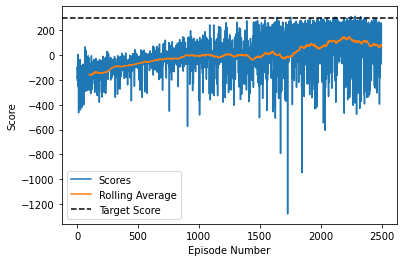

In [69]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.axhline(config.get('target_score'), color='k', linestyle="dashed", label="Target Score")
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")


Finally, we use a kernel density estimator to plot the distribution of scores. Note this is very much a bimodal distribution. The negative mode corresponds to those training episodes where the agent crash landed and thus scored negative rewards. The positive mode corresponds to those training episodes where the agent "solved" the task. 

The kernel density or scores typically exhibits negative skewness. This is since there are lots of ways in which landing the lander can go wrong (resulting in the agent getting a very low score) and only relatively few paths to a gentle landing (and a high score).

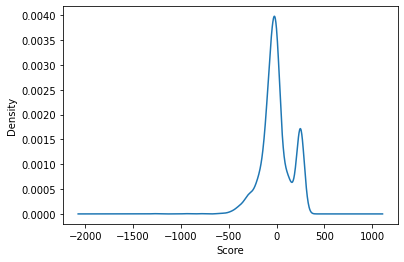

In [70]:
fig, ax = plt.subplots(1,1)
_ = scores.plot(kind="kde", ax=ax)
_ = ax.set_xlabel("Score")